In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# train_example = "/kaggle/input/cdiscount-image-classification-challenge/train_example.bson"
# train = "/kaggle/input/cdiscount-image-classification-challenge/train.bson"
# category_names = "/kaggle/input/cdiscount-image-classification-challenge/category_names.csv"
# test = "/kaggle/input/cdiscount-image-classification-challenge/test.bson"
# sample_submission = "/kaggle/input/cdiscount-image-classification-challenge/sample_submission.csv"

train_example_bson = './train_example.bson'

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io
import bson
from PIL import Image
# from skimage.io import imread
# import multiprocessing as mp

In [6]:
# class PrepareData():
#     def __init__():
#         super(PrepareData, self).__init__()
#         print("PrepareData Class")
    
#     def select_document_samples(self, n_per_class):
        

In [7]:
data = bson.decode_file_iter(open(train_example_bson, 'rb'))
# next(iter(data))

In [8]:
!pip install bson
!pip install pymongo

In [9]:
# so there is _id, imgs, and category_id

In [51]:
%%time

prod_id = []
cat_id = []
img_arr = []

for c, d in enumerate(data):
    product_id = d['_id']
    category_id = d['category_id'] # This won't be in Test data
#     prod_to_category[product_id] = category_id
    for e, pic in enumerate(d['imgs']):
        picture = imread(io.BytesIO(pic['picture']))
        
        prod_id.append(product_id)
        cat_id.append(category_id)
        img_arr.append(picture)
        
df = pd.DataFrame(list(zip(img_arr, prod_id, cat_id)), columns=['img_arr', 'prod_id', 'cat_id'])
df.head()

CPU times: user 100 ms, sys: 13 ms, total: 113 ms
Wall time: 112 ms


,img_arr,prod_id,cat_id
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,1000010653
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1,1000010653
2,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",2,1000004079
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,1000004141
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4,1000015539


In [52]:
df.shape

(110, 3)

In [53]:
# There is duplication in this dataset
df[df['prod_id'] == 13]

,img_arr,prod_id,cat_id
12,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",13,1000010961
13,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",13,1000010961
14,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",13,1000010961
15,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",13,1000010961


In [54]:
%%time

# multiprocessing in inserting dataset to df
NCORE =  8

prod_id = mp.Manager().list()
cat_id = mp.Manager().list()
img_arr = mp.Manager().list()

def process(q, iolock):
    while True:
        d = q.get()
        if d is None:
            break
        product_id = d['_id']
        category_id = d['category_id']
        for e, pic in enumerate(d['imgs']):
            picture = imread(io.BytesIO(pic['picture']))
            # do something with the picture, etc
            prod_id.append(product_id)
            cat_id.append(category_id)
            img_arr.append(picture)
        
    
q = mp.Queue(maxsize=NCORE)
iolock = mp.Lock()
pool = mp.Pool(NCORE, initializer=process, initargs=(q, iolock))

# process the file

data = bson.decode_file_iter(open('/kaggle/input/cdiscount-image-classification-challenge/train_example.bson', 'rb'))
for c, d in enumerate(data):
    q.put(d)  # blocks until q below its max size

# tell workers we're done

for _ in range(NCORE):  
    q.put(None)
pool.close()
pool.join()

prod_id = list(prod_id)
cat_id = list(cat_id)
img_arr = list(img_arr)

df = pd.DataFrame(list(zip(img_arr, prod_id, cat_id)), columns=['img_arr', 'prod_id', 'cat_id'])
df.head()

CPU times: user 56.4 ms, sys: 120 ms, total: 177 ms
Wall time: 466 ms


,img_arr,prod_id,cat_id
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,1000010653
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1,1000010653
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",8,1000010667
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",6,1000005744
4,"[[[255, 251, 255], [255, 252, 255], [255, 254,...",2,1000004079


In [55]:
df.shape

(110, 3)

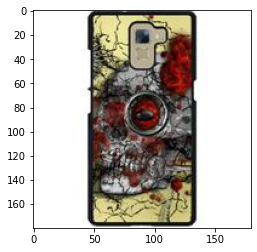

In [58]:
plt.imshow(df['img_arr'][0])

In [59]:
df['cat_id'].value_counts()

1000010653    39
1000010667     9
1000004079     6
1000010961     4
1000001859     4
1000005796     4
1000003787     3
1000010683     3
1000012989     2
1000004141     2
1000018294     2
1000018290     2
1000014287     2
1000015309     2
1000003191     2
1000013922     2
1000010647     2
1000011423     2
1000015539     1
1000007138     1
1000012993     1
1000004085     1
1000005744     1
1000003977     1
1000005990     1
1000014053     1
1000010706     1
1000010461     1
1000012558     1
1000010641     1
1000010645     1
1000005910     1
1000007361     1
1000018306     1
1000014396     1
1000010061     1
Name: cat_id, dtype: int64